In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install gurobipy
import gurobipy as gp
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 325 kB/s 


In [ ]:
#Reading train and test dataset while adding X0 for intercept
train_df = pd.read_csv("training_data.csv")
train_df.insert(1, 'X0', [1]*len(train_df)) # Inserting X0 value in column 2
test_df = pd.read_csv("test_data.csv")
test_df.insert(1, 'X0', [1]*len(test_df))
train_df.shape, test_df.shape

((250, 52), (50, 52))

In [ ]:
train_df.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,1,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,1,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,1,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,1,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,1,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [ ]:
test_df.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,7.107949,1,-2.047008,0.260132,-0.785152,0.384576,-0.137613,-0.364566,-1.941253,-0.108180,...,-0.522194,1.861897,0.124511,1.144071,0.128179,-0.467972,-1.085601,0.659670,0.514719,0.806656
1,5.796272,1,-1.354328,-1.289884,1.321533,-0.091165,-1.021874,0.686778,0.089737,-0.398371,...,-0.502578,0.584476,0.680703,0.046788,0.569681,-1.099062,-0.069656,0.709273,-0.848665,0.996168
2,1.598651,1,0.502205,1.062887,1.460733,-1.506403,0.721664,0.528921,-0.699541,-0.270331,...,-0.125195,-1.292924,0.411785,-0.164210,-2.407403,-1.132500,0.452923,-0.945541,0.126523,-0.972075
3,2.532953,1,0.222381,-0.960747,-0.113762,1.935927,0.969387,-1.641403,0.026647,0.747138,...,-0.546915,-0.192517,0.603420,-0.277331,-1.451419,0.220775,0.474954,-0.160109,0.188047,-1.711229
4,0.590685,1,1.209949,1.586874,-0.694784,-0.226370,-0.152108,0.772356,-0.573741,-0.992492,...,-0.982236,-1.407777,0.094211,0.159960,-0.901612,-1.653122,0.393518,0.702539,0.552663,-0.773646


In [ ]:
len(train_df)

250

## Question 1

###  Function 1 : K-Fold Cross Validation

In [ ]:
#Splitting training dataset in 10-folds for cross validation
def cv_split(data_idx, k=10):
    data_split = list()
    data_copy = data_idx.copy()
    size = int(len(data_idx) / k)
    for i in range(k):
        fold = list()
        while len(fold) < size and len(data_copy) > 0:
            idx = data_copy[0]
            fold.append(data_copy.pop(0))
        data_split.append(fold)
    return data_split

In [ ]:
train_idx = list(train_df.index.values)
split_idx = cv_split(train_idx)

## Question 2

### Function 2 : Optimizing Solutions using Gurobi

In [ ]:
def Solver(m_var, A, sense, b, lb = None, ub = None, min_max = 'maximize', vtype = None, Q = None, L = None, C = 0, show_output = False, time_limit = 3600):
    ''' 
    The Gurobi Optimizer is run to optimize xT @ Q @ x + L @ x + C with constraint matrix A @ x sense b.
    '''
    model = gp.Model()                                         #Model Initialization
    modelX = model.addMVar(m_var, lb=lb, ub=ub, vtype=vtype)   #Including Variables
    modelConstr = model.addMConstr(A, modelX, sense, b)        #Constructing model by incoporating constraint matrix 
    
    if min_max == 'maximize':
        model.setMObjective(Q,L,C,sense=gp.GRB.MAXIMIZE)
    if min_max == 'minimize':
        model.setMObjective(Q,L,C, sense = gp.GRB.MINIMIZE)
    
    model.Params.OutputFlag = 0
    model.setParam('TimeLimit', time_limit)
    
    model.optimize()
    
    return modelX.x

### Function 3 : Formulating MIQP Model for Optimization

In [ ]:
def MIQP_Solver(X, y, k, M, m, time_limit):    
    '''
    MIQP model is solved using big M contraint
    '''
    q = 2*m+1                                            #Quadratic expression
    Q = np.zeros((q,q))
    Q[0:m+1, 0:m+1] = X.T @ X
    L = np.array(list(-2 * y.T @ X) + [0]*m)             #Linear expression
    
    A = np.zeros((q,q))                                  #Constraint expression
    sense = np.array(['']*q)
    b = np.array([0]*q)
    
    row = 0
    A[row:row+m, 1:m+1] = np.identity(m)                 # -Mz_j <= b_j
    A[row:row+m, m+1:q] = M*np.identity(m)
    sense[row:row+m] = ['>']*m
    b[row:row+m] = [0]*m    
    
    row+=m                          
    A[row:row+m, 1:m+1] = np.identity(m)                # b_j <= Mz_j 
    A[row:row+m, m+1:q] = -1*M*np.identity(m)
    sense[row:row+m] = ['<']*m
    b[row:row+m] = [0]*m
    
    row+=m                                              # sum(z_j) = k
    A[-1, m+1:q] = [1]*m
    sense[-1] = '<'
    b[-1] = k
    
    #Calling the Gurobi Optimizer for MIQP model
    beta_vals = Solver(m_var=q, A=A, sense=sense, b=b, lb=np.array([-M]*q), ub=np.array([M]*q), min_max='minimize',
                       vtype = ['C']*(m+1) + ['B']*m, time_limit=time_limit, Q=Q, L=L, C=0)
    
    return beta_vals

In [ ]:
def MIQP_Model(train, split_ix, train_ix, k_range, time_limit = 3600):
    ''' 
    Running MIQP for all varaibles in k_range
    '''
    mse_outer = {}
    m = train.shape[1] - 1
    
    for k in k_range:
        print(f"Running for k = {k}")
        mse_inner = []
        for i, cv_test_ix in enumerate(split_ix):
            cv_train_ix = list(set(train_ix) - set(cv_test_ix))
            cv_train, cv_test = train.iloc[cv_train_ix], train.iloc[cv_test_ix]

            y_train, X_train = cv_train['y'].values, cv_train.drop('y', axis = 1).values
            y_val, X_val = cv_test['y'].values, cv_test.drop('y', axis = 1).values

            beta_vals = MIQP_Solver(X = X_train, y = y_train, k = k, M = 100, m=X_train.shape[1]-1, time_limit = time_limit)
            
            pd.DataFrame(beta_vals).to_csv(f'beta_vals_{k}.csv')
            
            se = (X_val @ beta_vals[0:m] - y_val).T @ (X_val @ beta_vals[0:m] - y_val)
            mse = se / len(y_val)
            mse_inner.append(mse)
            
        mse_outer[k] = np.mean(mse_inner)
    
    return mse_outer

In [ ]:
m=train_df.shape[1]-2    #Max value of m for k value should be 50
mse_miqp = MIQP_Model(train_df, split_idx, train_idx, range(5, m+1, 5), time_limit = 7200)

Running for k = 5
Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19
Running for k = 10
Running for k = 15
Running for k = 20
Running for k = 25
Running for k = 30
Running for k = 35
Running for k = 40
Running for k = 45
Running for k = 50


In [ ]:
print(">>>>>>>> Evaluating Performance of MIQP for different k values")
for key,val in mse_miqp.items():
    print("For k = ",key, "MSE = ",val)

>>>>>>>> Evaluating Performance of MIQP for different k values
For k =  5 MSE =  3.6699162437521933
For k =  10 MSE =  2.8991505257152084
For k =  15 MSE =  3.0561997503564062
For k =  20 MSE =  3.196048803866832
For k =  25 MSE =  3.081931311576103
For k =  30 MSE =  3.3203296079032056
For k =  35 MSE =  3.3244160307996955
For k =  40 MSE =  3.389375005053933
For k =  45 MSE =  3.3846929430694708
For k =  50 MSE =  3.388738181400776


In [ ]:
optimium_k = pd.Series(mse_miqp).idxmin()
print("Best Value of k = ", optimium_k)

10

## Question 3

### Running Model with k =10 (Best Value of k with lowest MSE)

In [ ]:
X_train, y_train = train_df.drop('y', axis = 1).values , train_df['y'].values 
X_test , y_test = test_df.drop('y', axis = 1).values , test_df['y'].values

In [ ]:
m = train_df.shape[1]-2

beta_vals = MIQP_Solver(X = X_train, y = y_train, k = optimium_k, M = 100, m=m, time_limit = 3600)

error_test = (X_test @ beta_vals[0:m+1] - y_test).T @ (X_test @ beta_vals[0:m+1] - y_test)
mse_test = error_test / len(y_test)

In [ ]:
print("MSE with k = ",optimium_k," is ",mse_test)

MSE with k =  10  is  2.3365439645525248


## Question 4


### Running a LASSO Model

In [ ]:
# Removes the intercept term from the train and test set
# Note this change does not effect output for math reasons, but we do it here anyways as good practice and to show off
X_train_lasso = X_train[:,1:]
X_test_lasso = X_test[:,1:]
X_train_lasso

array([[-1.53541286e+00,  7.18887717e-01, -2.09914874e+00, ...,
        -4.71045042e-01, -1.13978107e+00, -2.60772742e-01],
       [-1.73460938e+00,  5.51981259e-01, -2.14767300e+00, ...,
        -2.42564880e-01, -1.82662085e-03,  1.18745316e+00],
       [ 9.72566647e-02,  1.07634348e-01, -1.94222301e-01, ...,
        -7.51230919e-01,  1.45060937e+00,  2.90593419e-01],
       ...,
       [ 9.12367152e-02,  4.73697596e-01,  5.18318072e-02, ...,
        -8.41853603e-02, -2.00142679e-01,  8.40785925e-01],
       [-1.40700336e+00,  5.10885944e-01, -2.07758443e+00, ...,
        -5.22506923e-02,  5.43761518e-01,  2.74006244e-01],
       [-1.95950543e+00,  2.71732927e-01, -5.75357413e-01, ...,
         2.05276206e+00,  3.35630224e-02, -1.19848557e+00]])

In [ ]:
# Cross validates to select best lambda value. Fits entire data on the entire dataset
from sklearn.linear_model import LassoCV

# CV LASSO and fit on train
lasso = LassoCV(cv = 10).fit(X_train_lasso, y_train)

# Coefficients of Model
lasso.coef_

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.16054765,  0.        ,
       -0.05964031, -0.        , -0.        , -0.        , -0.41912484,
       -0.19325408,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.19517759, -1.36388738,  0.7425965 , -0.        ,
       -1.30481574, -0.        ,  0.        ,  0.05798283,  0.        ,
       -0.        ,  0.        , -0.09737839,  0.28341629,  0.        ,
        0.        ,  0.        ,  0.        , -0.23157873,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.03078191,  1.56362172,
       -0.02160033,  0.69992447, -0.09289745,  0.        ,  0.        ])

In [ ]:
# Prediction of y-values
y_hat = lasso.predict(X_test_lasso)
lasso_mse = np.mean((y_test - y_hat)**2)
n_lasso_selected = sum(lasso.coef_ != 0)
print("MSE with lambda = ",lasso.alpha_," is ",lasso_mse, "with", n_lasso_selected, "variables selected.")

MSE with lambda =  0.07638765995113514  is  2.3496347591605797 with 17 variables selected.


Text(0.5, 1.0, 'Histogram of Optimal MIQP Coefficients')

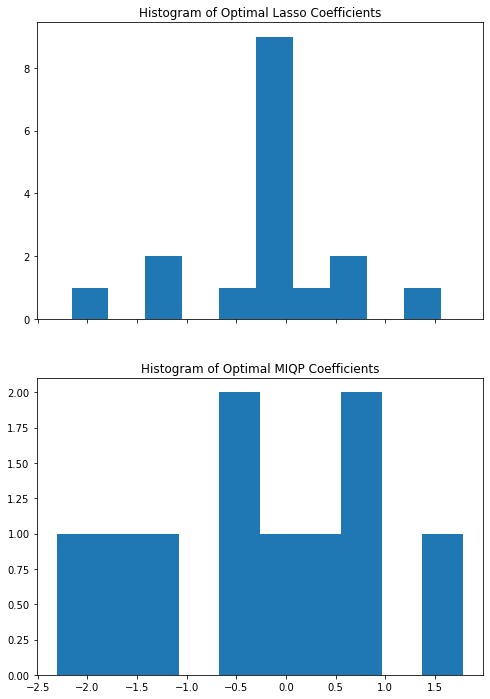

In [ ]:
# Average Size of Coefficients
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (8,12))

# Pulls MIQP coefficients from optimization output
MIQP_coef = beta_vals[:51]

ax1.hist(lasso.coef_[lasso.coef_ != 0])
ax1.set_title("Histogram of Optimal Lasso Coefficients")
ax2.hist(MIQP_coef[1:][MIQP_coef[1:] != 0])
ax2.set_title("Histogram of Optimal MIQP Coefficients")